# AI in Finance Project: Buy the Close, Sell the Open

In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.signal import find_peaks
from xgboost import XGBRegressor

In [2]:
#Silence some annoying errors
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
#Set directory
# os.chdir('/Users/19052/Desktop/')

# Hypothesis

See: https://www.businessinsider.com/stocks-fall-during-regular-trading-hours-rise-overnight-2016-3 for hypothesis. The strategy here is to buy the close and sell at open next morning, the features will be 20 days of open price, close price, and volume data, as well as weekday ordinally encoded. May also add a sliding window variance feature. Target is the percent difference between next days close price, and the day after thats open price. Assuming you would need to decide a day before the trade, might also include day of open price.

# Importing Data 

In [4]:
#pulling in data, top 10 US tech stocks by market cap (omitted TSLA, because not really tech))
StackedPrices = pd.read_csv("TechStocks.csv")
StackedPrices.date = pd.to_datetime(StackedPrices.date) 
StackedPrices.PRC = abs(StackedPrices.PRC) 

#Dropping these features for now
StackedPrices = StackedPrices.drop(['PERMNO'], axis = 1)
StackedPrices = StackedPrices.drop(['BID'], axis = 1)
StackedPrices = StackedPrices.drop(['ASK'], axis = 1)
StackedPrices = StackedPrices.drop(['NUMTRD'], axis = 1)

#Added high and low of day
#StackedPrices = StackedPrices.drop(['BIDLO'], axis = 1)
#StackedPrices = StackedPrices.drop(['ASKHI'], axis = 1) 

#Remove voting shares of Google and sorting
StackedPrices = StackedPrices[StackedPrices['TICKER'] != "GOOGL"] 
StackedPrices.sort_values(by=['TICKER', 'date'], inplace=True)

StackedPrices.head()

,date,TICKER,BIDLO,ASKHI,PRC,VOL,OPENPRC
4024,2016-01-04,AAPL,102.00,105.368,105.35,69383612,102.61
4025,2016-01-05,AAPL,102.41,105.850,102.71,55791042,105.75
4026,2016-01-06,AAPL,99.87,102.370,100.70,68487388,100.56
4027,2016-01-07,AAPL,96.43,100.130,96.45,81466204,98.68
4028,2016-01-08,AAPL,96.76,99.110,96.96,70798746,98.55


In [5]:
#useful function for unpivoting tables
def MyStack(X):
    X = X.stack(dropna=False)
    X.reset_index(inplace=True)
    X.sort_values(by=['TICKER', 'date'], inplace=True)
    return(X)

In [6]:
#list of tickers
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

#List of values
Values = ['PRC','VOL', 'OPENPRC', 'ASKHI', 'BIDLO']

# For splitting data
TestYear = 2019

In [7]:
#Unstacking Data
UnstackedPrices = pd.pivot_table(StackedPrices, values=Values, index=['date'], columns=['TICKER'], aggfunc=np.sum)

# Feature Engineering Part 1

In [8]:
#Adding rolling window features

#20 day rolling standard deviation of price
for i in Tick:
    UnstackedPrices['20STDPRC', i] = UnstackedPrices['PRC', i].rolling(window=20).std()

#5 day rolling standard deviation of price
for ii in Tick:
    UnstackedPrices['5STDPRC', ii] = UnstackedPrices['PRC', ii].rolling(window=5).std()
    
#5 day rolling mean of price
for iii in Tick:
    UnstackedPrices['5AVGPRC', iii] = UnstackedPrices['PRC',iii].rolling(window=5).mean()
    
#5 day rolling stdev of volume
for iiii in Tick:
    UnstackedPrices['5STDVOL', iiii] = UnstackedPrices['PRC',iiii].rolling(window=5).mean()

#Open Price day of trade
OpenPrc1 = UnstackedPrices['OPENPRC'].shift(periods=-1)

for v in Tick:
    UnstackedPrices['OPENTRD', v] = OpenPrc1[v] 

In [9]:
#Saving these on the side to reassemble dataframe after its converted to numpy array with scaler
col = UnstackedPrices.columns
idx = UnstackedPrices.index

# Split train/test data
data_train = UnstackedPrices[UnstackedPrices.index.year != TestYear]
data_test = UnstackedPrices[UnstackedPrices.index.year == TestYear]

#Normalizing data
scaler = StandardScaler()
data_train_sc = scaler.fit_transform(data_train)
data_test_sc = scaler.transform(data_test)
X = np.vstack((data_train_sc, data_test_sc))

#Reassembling Dataframe
NormPrices = pd.DataFrame(X)
NormPrices.index = idx
NormPrices.columns = col
#NormPrices.head()

In [10]:
NormPrices.tail()

ASKHI                                                    \
TICKER          AAPL      AMZN        FB      GOOG      INTC      MSFT   
date                                                                     
2019-12-24  3.555799  1.597832  2.021334  2.514406  2.529464  3.996063   
2019-12-26  3.689201  1.773359  2.057812  2.581222  2.578577  4.046374   
2019-12-27  3.793773  1.845876  2.097120  2.600560  2.662202  4.086820   
2019-12-30  3.760226  1.805094  2.060644  2.530949  2.605125  4.060678   
2019-12-31  3.786173  1.733046  1.977776  2.440388  2.589196  3.999022   

                                                    ...   OPENTRD            \
TICKER          NFLX      NVDA      ORCL      PYPL  ...      AAPL      AMZN   
date                                                ...                       
2019-12-24  1.394007  1.130859  1.910244  2.482358  ...  3.624311  1.652604   
2019-12-26  1.401751  1.143284  1.846789  2.506822  ...  3.791236  1.846972   
2019-12-27  1.374907  1.143530  1.876401  2.528291  ...  3.747252  1.825805   
2019-12-30  1.327817  1.092601  1.810830  2.499333  ...  3.759705  1.749871   
2019-12-31  1.284446  1.086143  1.707187  2.441917  ...       NaN       NaN   

                                                                        \
TICKER            FB      GOOG      INTC      MSFT      NFLX      NVDA   
date                                                                     
2019-12-24  2.048295  2.571391  2.618114  4.061271  1.435725  1.165114   
2019-12-26  2.159334  2.674391  2.685753  4.155538  1.418768  1.178095   
2019-12-27  2.130357  2.594844  2.696576  4.132445  1.378648  1.130541   
2019-12-30  1.992036  2.473045  2.646523  4.021869  1.305440  1.067009   
2019-12-31       NaN       NaN       NaN       NaN       NaN       NaN   

                                
TICKER          ORCL      PYPL  
date                            
2019-12-24  1.893169  2.542528  
2019-12-26  1.938037  2.595057  
2019-12-27  1.882486  2.562283  
2019-12-30  1.705147  2.461987  
2019-12-31       NaN       NaN  

[5 rows x 100 columns]

# Visualization & Exploration

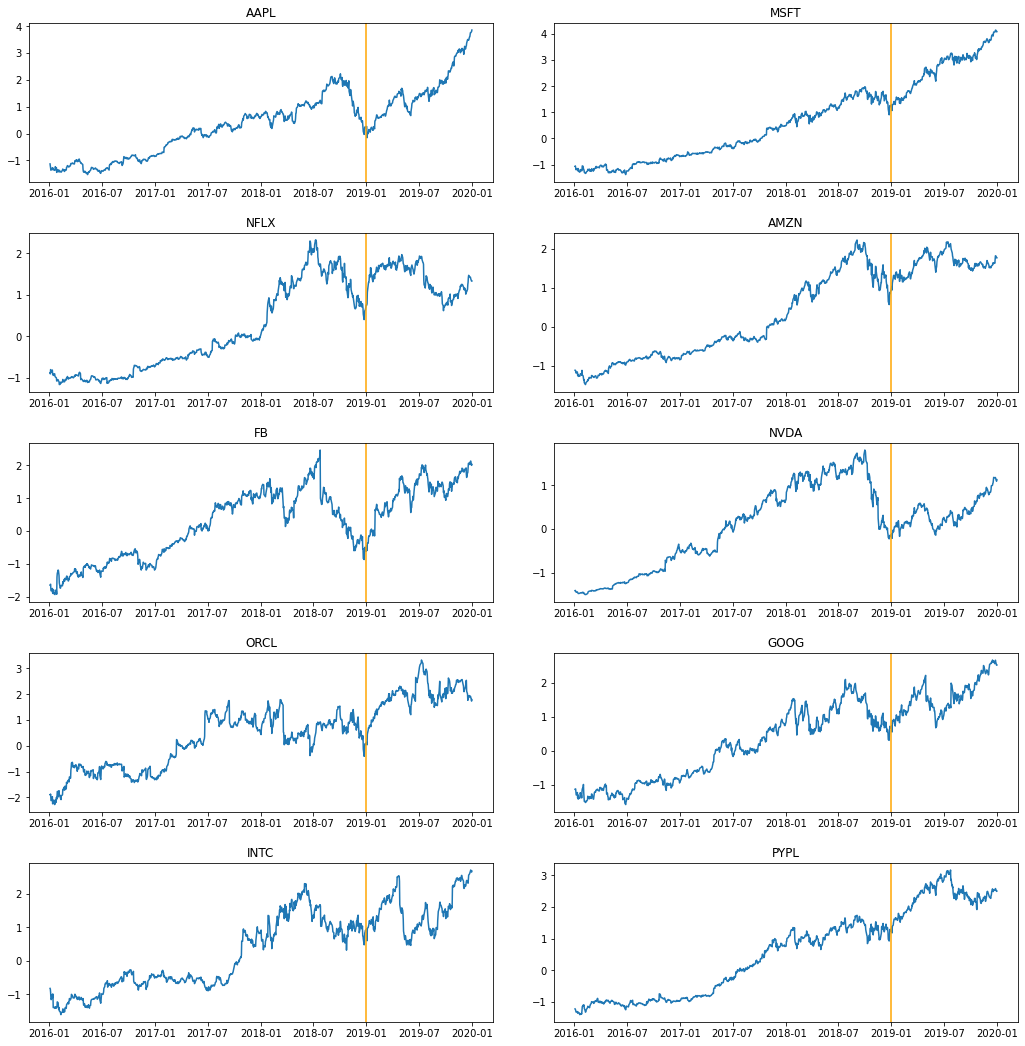

In [11]:
#Subplots of alls stocks
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

fig, axs = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout(pad=3.0)

for i in range(len(Tick)):
    axs[i%5, i%2].plot(NormPrices['PRC',Tick[i]])
    axs[i%5, i%2].set_title(Tick[i])
    #Added in line where test data will be split
    axs[i%5, i%2].axvline(dt.datetime(2018, 12, 31), color='orange')


In [12]:
#To check how many Nulls etc
#UnstackedPrices.info()

In [13]:
#To examine values and distibutions/ make sure normalizaiton worked
#UnstackedPrices.describe()

# Feature Engineering Part 2

In [14]:
#Feature names to lag, and steps to lag by
Feat = ['PRC','VOL', 'OPENPRC',  'ASKHI', 'BIDLO', 'WKDY'] 
Steps = 20

In [15]:
#Trimming data
NormPrices = NormPrices[:-2] #drop two rows, used to calculate returns
NormPrices = NormPrices[20:] #drop 20 rows, used to calculate volatility

#Need this for unlagged variables
NormPrices2 = NormPrices[Steps:] #trim data used to calculate lags
NormPrices2 = NormPrices2.stack(dropna=False)
NormPrices2 = pd.DataFrame(NormPrices2)
NormPrices2.reset_index(inplace=True)
NormPrices2.sort_values(by=['TICKER', 'date'], inplace=True)

#Unlagged variables, saving for later 
OPENTRD = NormPrices2['OPENTRD']
FIVESTDPRC = NormPrices2['5STDPRC']
TWENTYSTDPRC = NormPrices2['20STDPRC']
AVGPRC = NormPrices2['5AVGPRC']
STDVOL = NormPrices2['5STDVOL']

#Restacking Data
NormPrices = MyStack(NormPrices)

#Adding day of week
NormPrices['WKDY'] = NormPrices['date'].dt.dayofweek #lag or dont lag weekeday???
NormPrices.reset_index(inplace=True, drop=True)

In [16]:
#Function to add lagged variables based on steps, and assembles data frame
def LagVar(X, steps, values):
    
    UnstackX = pd.pivot_table(X, values=values, index=['date'], columns=['TICKER'], aggfunc=np.sum)
    UnstackXTrim = UnstackX[steps:]
    UnstackXTrim  = MyStack(UnstackXTrim)
    UnstackXTrim.reset_index(inplace=True, drop=True)
    
    X = UnstackXTrim
    
    for i in range(steps):
 
        Shifted1 = UnstackX.shift(periods=i+1)
        Shifted1 = Shifted1[steps:]
        Shifted2 = Shifted1.stack(dropna=False)
        Shifted2.reset_index(inplace=True)
        Shifted2.sort_values(by=['TICKER', 'date'], inplace=True)
        Shifted2.reset_index(inplace=True, drop=True)
        Shifted3 = Shifted2.add_prefix(('Lag_' + str(i+1) + '_' ))
        Shifted3.drop([('Lag_' + str(i+1) + '_date' )], axis=1, inplace=True)
        Shifted3.drop([('Lag_' + str(i+1) + '_TICKER' )], axis=1, inplace=True)

        X = pd.concat([X, Shifted3], axis = 1)
    
    return(X)

In [17]:
#Lagging data
LagData = LagVar(NormPrices, Steps, Feat) 
LagData.reset_index(inplace=True, drop=True)
LagData.head() #Check for NaNs

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.402013,-1.369251,0.838201,2.0,-1.393714,-1.404751,-1.390895,-1.418814,0.269771,1.0
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.379248,-1.362625,0.866888,3.0,-1.372748,-1.410107,-1.402013,-1.369251,0.838201,2.0
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.361777,-1.431005,0.863348,4.0,-1.359905,-1.380378,-1.379248,-1.362625,0.866888,3.0
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.451514,-1.404766,1.361416,0.0,-1.370651,-1.420552,-1.361777,-1.431005,0.863348,4.0
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.420807,-1.405296,0.726635,1.0,-1.402625,-1.437961,-1.451514,-1.404766,1.361416,0.0


In [18]:
LagData.tail() #Check for NaNs if issue

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
9635,2019-12-20,PYPL,2.500332,2.569228,2.553239,2.528225,0.305868,4,2.466381,2.534768,...,2.231083,2.174361,-0.465589,4.0,2.243207,2.261659,2.235136,2.213904,-0.219171,3.0
9636,2019-12-23,PYPL,2.491844,2.582087,2.541589,2.521128,-0.874720,0,2.500332,2.569228,...,2.203730,2.310228,-0.034317,0.0,2.181297,2.188110,2.231083,2.174361,-0.465589,4.0
9637,2019-12-24,PYPL,2.482358,2.582087,2.520821,2.525184,-1.550875,1,2.491844,2.582087,...,2.326312,2.398948,1.061867,1.0,2.248199,2.257030,2.203730,2.310228,-0.034317,0.0
9638,2019-12-26,PYPL,2.506822,2.591859,2.545641,2.578922,-1.011254,3,2.482358,2.582087,...,2.432177,2.477528,-0.213383,2.0,2.358539,2.382527,2.326312,2.398948,1.061867,1.0
9639,2019-12-27,PYPL,2.528291,2.608832,2.598168,2.561178,-1.163451,4,2.506822,2.591859,...,2.486883,2.490710,-0.921634,4.0,2.431432,2.500822,2.432177,2.477528,-0.213383,2.0


# Target

In [19]:
#Close price from next day
ClosePrc = UnstackedPrices['PRC'].shift(periods=-1)
ClosePrc = ClosePrc[:-2]
ClosePrc = ClosePrc[Steps+20:]
ClosePrc = ClosePrc.stack(dropna=False)
ClosePrc = pd.DataFrame(ClosePrc)
ClosePrc.reset_index(inplace=True)
ClosePrc.sort_values(by=['TICKER', 'date'], inplace=True)
ClosePrc.rename({0: 'PRC'}, axis=1, inplace = True)

#Open price from day after
OpenPrc2 = UnstackedPrices['OPENPRC'].shift(periods=-2)
OpenPrc2 = OpenPrc2[:-2]
OpenPrc2 = OpenPrc2[Steps+20:]
OpenPrc2 = OpenPrc2.stack(dropna=False)
OpenPrc2 = pd.DataFrame(OpenPrc2)
OpenPrc2.reset_index(inplace=True)
OpenPrc2.sort_values(by=['TICKER', 'date'], inplace=True)
OpenPrc2.rename({0: 'OPENPRC'}, axis=1, inplace = True)

In [20]:
#Calculating Log Returns
OpenPrc2['ClosePrc'] = ClosePrc['PRC']
OpenPrc2['Returns'] = np.log(OpenPrc2['OPENPRC']/OpenPrc2['ClosePrc'])
Returns = pd.DataFrame(OpenPrc2['Returns'])
Returns.reset_index(inplace=True, drop=True)

array([[<AxesSubplot:title={'center':'Returns'}>]], dtype=object)

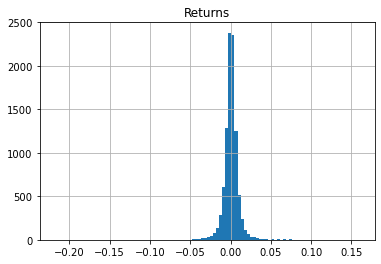

In [21]:
#Distribution of returns
Returns.hist(bins=100)

In [22]:
#Add year for splitting based on year
LagData['YEAR'] = LagData['date'].dt.year

#Adding back unlagged variables
LagData['RET'] = Returns 
LagData['OPENTRD'] = OPENTRD
LagData['5STDPRC'] = FIVESTDPRC
LagData['20STDPRC'] = TWENTYSTDPRC
LagData['5AVGPRC'] = AVGPRC
LagData['5STDVOL'] = STDVOL

In [23]:
LagData.head()

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY,YEAR,RET,OPENTRD,5STDPRC,20STDPRC,5AVGPRC,5STDVOL
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.418814,0.269771,1.0,2016,0.008535,-1.257315,0.177648,-0.775594,-1.320622,-1.320622
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.369251,0.838201,2.0,2016,-0.006037,-1.249616,-0.181427,-0.102754,-1.282946,-1.282946
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.362625,0.866888,3.0,2016,-0.010758,-1.362924,-0.372550,-0.022999,-1.431693,-1.431693
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.431005,0.863348,4.0,2016,0.002768,-1.271137,-0.211773,-0.601101,-1.330781,-1.330781
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.404766,1.361416,0.0,2016,0.002864,-1.207542,-0.201640,-0.639447,-1.367950,-1.367950


# Splitting Data

In [24]:
#Splitting data, 2019 is test set
X_train = LagData[LagData['YEAR'] != TestYear]
X_train.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)

y_train = LagData[LagData['YEAR'] != TestYear]
y_train = y_train['RET']

X_test = LagData[LagData['YEAR'] == TestYear]
X_test.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)

y_test = LagData[LagData['YEAR'] == TestYear]
y_test = y_test['RET']

# Model Implementation (WIP)

In [25]:
# Set up hyperparameter tuning for Random Forest
# Number of trees in random forest
n_estimators = [25, 50, 75, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 10]
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(rf_grid)

# Initialize model
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
cv = RandomizedSearchCV(rf, rf_grid, n_iter=10, cv=3, random_state=42, n_jobs = -1)
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 7, 10], 'min_samples_leaf': [10, 20, 30, 40, 50], 'bootstrap': [True]}
{'n_estimators': 75, 'min_samples_leaf': 40, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [26]:
# Re-train on full dataset using best parameters
rf_best = RandomForestRegressor(n_estimators = 75, 
                                min_samples_leaf = 40,
                                max_features = 'auto',
                                max_depth = 10,
                                bootstrap = True, 
                                random_state=42)

rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=40, n_estimators=75,
                      random_state=42)

<AxesSubplot:>

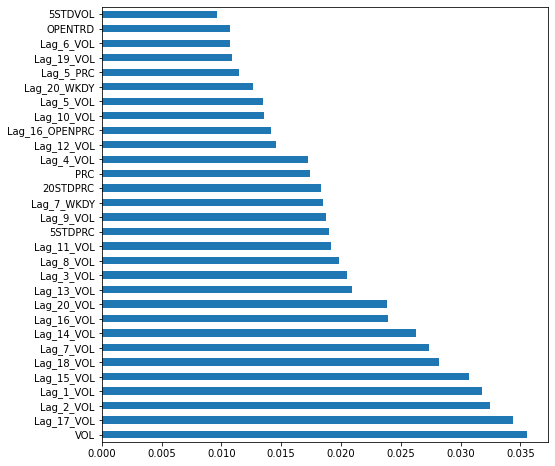

In [27]:
#Feature Importance
feat_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh', figsize=(8,8))

In [28]:
# Set up hyperparameter tuning for Gradient Boosted Trees (XGBoost)

# Number of trees 
n_estimators = [25, 50, 75, 100]
# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 10]
# Learning rate to prevent overfitting
learning_rate = [0.1, 0.2, 0.3, 0.4]

xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate}
print(xgb_grid)

# Initialize model
xgbreg = XGBRegressor(nthreads=-1)
# Random search of parameters, using 3 fold cross validation, 
cv = RandomizedSearchCV(xgbreg, xgb_grid, cv=3, n_iter=10, random_state=42, n_jobs=-1)  
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_depth': [2, 3, 5, 7, 10], 'learning_rate': [0.1, 0.2, 0.3, 0.4]}
[21:38:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.1}


In [29]:
# Re-train on full dataset using best parameters
xgbreg_best = XGBRegressor(n_estimators = 75, max_depth = 5, learning_rate = 0.1, random_state=42)

xgbreg_best.fit(X_train, y_train)

[21:38:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, n_estimators=75, random_state=42)

<AxesSubplot:>

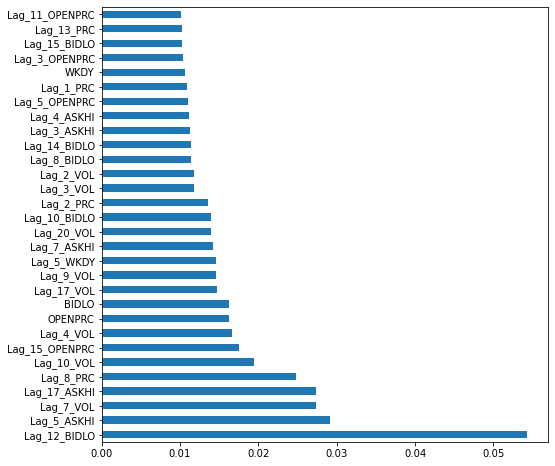

In [30]:
#Feature Importance
feat_importances = pd.Series(xgbreg_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh', figsize=(8,8))

# Model Evaluation (WIP)

In [31]:
# mean_squared_error(y_test, y_pred)

# Backtesting

In [32]:
#Setting up test data for backtesting

#Adding Prediction to test data
TestData = LagData[LagData['YEAR'] == TestYear]
TestData['PREDRET'] = rf_best.predict(X_test)

#Unstacking test data for backtesting
col = ['date', 'TICKER', 'RET', 'PREDRET']
XTrade = TestData[col]
XTrade = pd.pivot_table(XTrade, values=['RET', 'PREDRET'], index=['date'], columns=['TICKER'], aggfunc=np.sum)

#Setting up training data for backtesting optimization
TrainData = LagData[LagData['YEAR'] != TestYear]
TrainData['PREDRET'] = rf_best.predict(X_train)

#Unstacking train data for backtesting
col = ['date', 'TICKER', 'RET', 'PREDRET']
Xopt = TrainData[col]
Xopt = pd.pivot_table(Xopt, values=['RET', 'PREDRET'], index=['date'], columns=['TICKER'], aggfunc=np.sum)

In [33]:
#Backtesting function
def BackTest(X, Threshold, short=False):
    Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']
    
    for Tick in Tick:
        #Applying signal for each asset if threshold is passed
        X['SIGNAL', Tick] = 0
        
        #Apply buy signal
        mask = (X['PREDRET',Tick] > Threshold)
        X['SIGNAL', Tick][mask] = 1 
        
        if short == True:
            #Apply sell signal
            mask = (X['PREDRET',Tick] < -Threshold)
            X['SIGNAL', Tick][mask] = -1 
        
        #Calculating Returns based on signals
        X['TRADERET', Tick] = X['SIGNAL', Tick] * X['RET', Tick] 
    
    #Calculating returns
    X['HOLDINGS'] = (X['SIGNAL'].abs()).sum(axis=1) #Number of assets bought each day, used to find average return
    X['TOTRET'] = (X['TRADERET'].sum(axis=1) / X['HOLDINGS']) #total returns by number of holding, this is portfolio returns
    X['TOTRET'] = X['TOTRET'].fillna(0) 
    
    #Cummulative Returns
    X['STRAT_CUMRET'] = X['TOTRET'].cumsum() #Cummulative Returns
    X['LONG_CUMRET'] = (X['RET'].sum(axis=1)/10).cumsum() #Returns for equal position long portfolio
    
    #Strategy metrics
    strat_ann_vol = X['TOTRET'].std()*math.sqrt(252)
    strat_ann_ret = ((X['TOTRET'].mean()+1)**252) - 1
    strat_ann_sr = X['TOTRET'].mean()/(X['TOTRET'].std())*math.sqrt(252) #Sharpes Ratio
    
    #Baseline Long Portfolio metrics
    long_ann_vol = (X['RET'].sum(axis=1)/10).std()*math.sqrt(252)
    long_ann_ret = (((X['RET'].sum(axis=1)/10).mean()+1)**252) - 1
    long_ann_sr = (X['RET'].sum(axis=1)/10).mean()/((X['RET'].sum(axis=1)/10).std())*math.sqrt(252)
    
    return(X, strat_ann_vol, strat_ann_ret, strat_ann_sr, long_ann_vol, long_ann_ret, long_ann_sr)

In [34]:
#optimizing threshold parameter based on training data
def BackTestOpt(X):

    lin = np.linspace(0, 0.005, 200)
    returns = []
    
    #Testing Various Thresholds
    for i in lin:
        Y, strat_ann_vol, strat_ann_ret, strat_ann_sr, long_ann_vol, long_ann_ret, long_ann_sr = BackTest(X, i)
        returns.append(strat_ann_ret)
    
    
    df = (pd.DataFrame([lin, returns])).T
    df.columns = ['Threshold','Returns']
    df['rollavg'] = df['Returns'].rolling(window=5).mean() #Smoothing out bumps
    
    #Finding threshold with max returns
    idx = df['rollavg'].idxmax()
    val1 = df['Returns'][idx]
    val2 = df['Threshold'][idx]
    
    #Plotting Threshold vs annualized Returns
    df.index = df['Threshold']
    df['Returns'].plot()
    df['rollavg'].plot()
    
    return(val1, val2)

0.00221


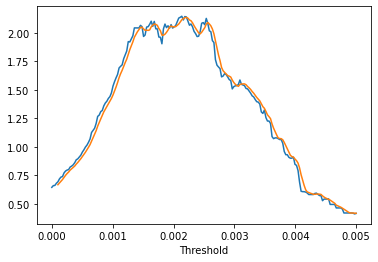

In [35]:
#Find optimal threshold based on train data, doesnt really work since model knows this data too well, cant generalize this threshold
ret, thresh = BackTestOpt(Xopt)
print(round(thresh,5))

0.00103


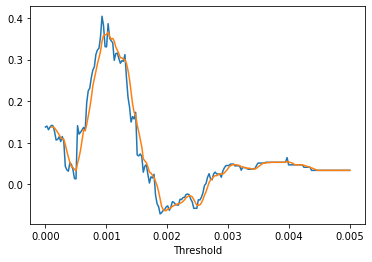

In [36]:
#Finding Optimal Threshold based on test data, cant do this in reality, would need to have other sets of data to optimize threshold on
ret, thresh = BackTestOpt(XTrade)
print(round(thresh,5))

# Trading Results

In [37]:
Threshold = 0.001 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh

In [38]:
#Backtest on test data with optimal or manual threshold
XTrade_rf, strat_ann_vol_rf, strat_ann_ret_rf, strat_ann_sr_rf, long_ann_vol_rf, long_ann_ret_rf, long_ann_sr_rf \
    = BackTest(XTrade, Threshold, short)

Strategy Results: Annualized Volatility: 0.1447 Annualized Returns: 0.3305 Sharpe Ratio: 1.9746
Equal Long Portfolio Results: Annualized Volatility: 0.1181 Annualized Returns: 0.2025 Sharpe Ratio: 1.5615


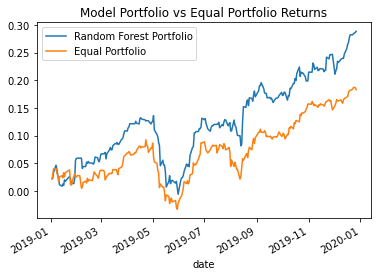

In [39]:
# Summarize results for random forest portfolio
XTrade_rf['STRAT_CUMRET'].shift(periods=1).plot()
XTrade_rf['LONG_CUMRET'].plot()
plt.legend(['Random Forest Portfolio', 'Equal Portfolio'], loc="upper left")
plt.title('Model Portfolio vs Equal Portfolio Returns')

print("Strategy Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f" \
      % (round(strat_ann_vol_rf,4), round(strat_ann_ret_rf,4), round(strat_ann_sr_rf,4)))
print("Equal Long Portfolio Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f" \
      % (round(long_ann_vol_rf,4), round(long_ann_ret_rf,4), round(long_ann_sr_rf,4)))

In [40]:
#White's Reality Check
def WRC():
    
    return()